# City Data Sheets
W.I.P.

Reference this
https://data-dive.com/jupyterlab-markdown-cells-include-variables

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import Markdown as md

# ISP Data Sheet
Leon Yin

In [3]:
import glob
import pandas as pd
from analysis import race, income, redlining, bucket_and_bin, income_labels, race_bins, speed_breakdown

In [4]:
from config import cities
from utils import read_ndjson

In [5]:
isp2isp = {
    'att': 'AT&T',
    'earthlink': 'EarthLink',
    'centurylink': 'CenturyLink',
    'verizon': 'Verizon'
}

In [10]:
record = cities[0]

In [11]:
record['city']

'DETROIT'

In [12]:
len(cities)

50

In [32]:
city = record.pop('city').title()
state = record.pop('state')
md(f"## {city}, {state}.")

## Detroit, MI.

In [13]:
data_source = "OpenAddresses" if "open_addresses" in record['fn'] else "NYC Open Data"

In [15]:
n_addresses = len(read_ndjson(record['fn'])

In [33]:
isps = [isp2isp.get(k) for k in record.keys()]

In [34]:
isps

['AT&T', 'EarthLink']

In [23]:
dataframes = {}
if 'AT&T' in isps:
    _df = pd.read_csv('../data/output/speed_price_att.csv.gz', compression='gzip')
    _df = _df[(_df.major_city == city.lower()) & (_df.state == state)]
    dataframes['AT&T'] = _df
elif 'Verizon' in isps:
    _df = pd.read_csv('../data/output/speed_price_verizon.csv.gz', compression='gzip')
    _df = _df[(_df.major_city == city.lower()) & (_df.state == state)]
    dataframes['Verizon'] = _df
elif 'CenturyLink' in isps:
    _df = pd.read_csv('../data/outputs/speed_price_centurylink.csv.gz', compression='gzip')
    _df = _df[(_df.major_city == city.lower()) & (_df.state == state)]
    dataframes['ECenturyLink'] = _df
    
if 'EarthLink' in isps:
    _df = pd.read_csv('../data/output/speed_price_earthlink.csv.gz', compression='gzip')
    _df = _df[(_df.major_city == city.lower()) & (_df.state == state)]
    dataframes['EarthLink'] = _df
del _df

/home/chino/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/chino/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
dataframes

{'AT&T':                                 address_full incorporated_place major_city  \
 236587  3753 Montgomery St, Detroit MI 48206       Detroit city    detroit   
 236588   3732 Vicksburg St, Detroit MI 48206       Detroit city    detroit   
 236589     4007 Whitney St, Detroit MI 48204       Detroit city    detroit   
 236590     7439 Dexter Ave, Detroit MI 48206       Detroit city    detroit   
 236591   4011 Vicksburg St, Detroit MI 48204       Detroit city    detroit   
 ...                                      ...                ...        ...   
 262999      20214 Steel St, Detroit MI 48235       Detroit city    detroit   
 263000   20461 Appoline St, Detroit MI 48235       Detroit city    detroit   
 263001   20476 Appoline St, Detroit MI 48235       Detroit city    detroit   
 263002   20437 Appoline St, Detroit MI 48235       Detroit city    detroit   
 263003   20508 Appoline St, Detroit MI 48235       Detroit city    detroit   
 
        state        lat        lon availa

In [25]:
[f"{k} (N={len(v):,}" for k,v in dataframes.items()]

['AT&T (N=26,417', 'EarthLink (N=25,916']

In [28]:
md(f"We found {n_addresses:,} addresses for {city} using the open source dataset {data_source}."
   f" We collected 10 percent of available addresses for each Census block group from {' and '.join([f'{k} (N={len(v):,})' for k,v in dataframes.items()])} using their service lookup tools.")

We found 382,442 addresses for Detroit using the open source dataset OpenAddresses. We collected 10 percent of available addresses for each Census block group from AT&T (N=26,417) and EarthLink (N=25,916) using their service lookup tools.

## Findings

In [29]:
[len(_) for _ in dataframes.values()]

[26417, 25916]

In [30]:
dataframes.keys()

dict_keys(['AT&T', 'EarthLink'])

In [35]:
isp = isps[0]
_df = dataframes[isp]
_df = bucket_and_bin(_df)
perc_unserviceable = len(_df[_df.speed_down == 0]) / len(_df)

md(f"We found that {isp} does not service {perc_unserviceable * 100:.1f}% of addresses we checked.")

We found that AT&T does not service 18.8% of addresses we checked.

In [36]:
_df = _df[_df['speed_down'] != 0]

In [37]:
md(f"For addresses that AT&T does claim to serve, we found speeds were distributed:")

For addresses that AT&T does claim to serve, we found speeds were distributed:

In [38]:
from analysis import speed_labels, Line2D, plt

In [39]:
def speed_breakdown(df, location='National', isp='AT&T'):
    categories = set(df.speed_down_bins.unique())
    location = city
    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label=label, markerfacecolor=c, markersize=10)
                   for label, c in speed_labels.items() if label in categories][::-1]    

    ax = pd.DataFrame(df.speed_down_bins.value_counts(normalize=True).sort_index()[1:]).T.plot.barh(
        stacked=True, figsize=(8, 2.6), 
        color = [v for k,v in speed_labels.items() if k in categories]
    )
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.axes.yaxis.set_visible(False)
    
    ax.set_ylabel("")
    labels = ax.get_xticks().tolist()
    labels = [int(_* 100) for _ in labels]
    labels[0] = "0%"
    ax.set_xticklabels(labels)
    ax.set_xlabel("Percentage of residential Internet offers")

    ax.legend(handles=legend_elements[::-1],
              loc='lower left', 
              bbox_to_anchor= (-0.025, 1.0), 
              ncol=5,
              handletextpad=0.0,
              labelspacing=0, 
              borderaxespad=.1, 
              borderpad=0.1,
              frameon=False,
              prop={'size': 9.2})

    plt.title(f'{isp} {location} Residential Download Speeds (N={len(df):,})',
              loc='left', y=1.075, size=15.5)


<ipython-input-39-efc4ffc6efea>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


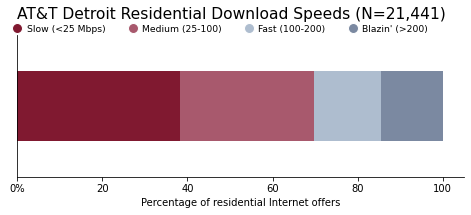

In [40]:
speed_breakdown(_df)

In [41]:
speed_min = _df.speed_down.min() 
speed_max = _df.speed_down.max()

In [42]:
md(f"We found plans at the same price with download speeds ranging from {speed_min} to {speed_max} Mbps.")

We found plans at the same price with download speeds ranging from 0.768 to 300.0 Mbps.

In [43]:
perc_fast = len(_df[(_df.speed_down >= 100) & (_df.speed_up >= 20)]) / len(_df)

In [44]:
perc_slow = len(_df[_df.speed_down < 25]) / len(_df)

In [45]:
# if perc_slow - perc_fast > 0:
    

In [46]:
md(f"We found that {perc_fast * 100:.1f}% of households have Internet with speeds of at least 100 down 20 up.")

We found that 30.2% of households have Internet with speeds of at least 100 down 20 up.

In [47]:
table = pd.read_csv('../data/output/tables/table1_cities_ranked_by_categories.csv')

In [52]:
table

,major_city,state,slowest_income,p_value_income,isp,prop_slow_income_exposure,prop_slow_income_treatment,prop_slow_income_delta,slowest_race,p_value_race,prop_slow_race_exposure,prop_slow_race_treatment,prop_slow_race_delta,slowest_redlining,p_value_redlining,prop_slow_redlining_exposure,prop_slow_redlining_treatment,prop_slow_redlining_delta
0,Atlanta,GA,True,7.715820e-13,AT&T,0.147996,0.085022,0.062974,True,4.292469e-01,0.088131,0.082686,0.005445,True,9.100916e-23,0.162162,0.032359,0.129803
1,Charleston,SC,True,2.621133e-87,AT&T,0.780069,0.093438,0.686631,True,2.072449e-33,0.893333,0.147830,0.745504,NaN,NaN,NaN,NaN,NaN
2,Charlotte,NC,True,1.202328e-32,AT&T,0.161336,0.038709,0.122627,True,1.484277e-09,0.127660,0.070880,0.056779,True,1.973672e-06,0.263804,0.125773,0.138030
3,Chicago,IL,True,5.887420e-23,AT&T,0.291315,0.221422,0.069893,True,2.825903e-04,0.250053,0.228948,0.021105,True,2.631264e-29,0.280234,0.197808,0.082425
4,Cleveland,OH,True,3.241185e-208,AT&T,0.739274,0.144424,0.594850,True,4.856428e-251,0.467090,0.081929,0.385161,True,0.000000e+00,0.591696,0.053061,0.538634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Portland,OR,NaN,NaN,EarthLink,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,Salt Lake City,UT,NaN,NaN,EarthLink,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,Seattle,WA,NaN,NaN,EarthLink,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,Sioux Falls,SD,NaN,NaN,EarthLink,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


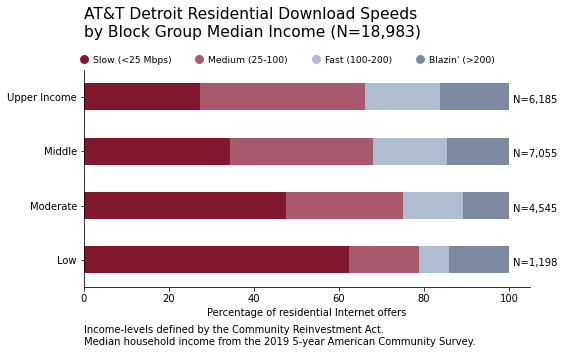

In [49]:
income(_df, location=city)

In [53]:
table_ = table[(table.major_city == city.title()) & (table.isp == isp)]

In [55]:
table_

,major_city,state,slowest_income,p_value_income,isp,prop_slow_income_exposure,prop_slow_income_treatment,prop_slow_income_delta,slowest_race,p_value_race,prop_slow_race_exposure,prop_slow_race_treatment,prop_slow_race_delta,slowest_redlining,p_value_redlining,prop_slow_redlining_exposure,prop_slow_redlining_treatment,prop_slow_redlining_delta
5,Detroit,MI,True,8.403074e-104,AT&T,0.624374,0.272433,0.351941,False,0.479805,0.314514,0.342282,-0.027768,True,0.0,0.676887,0.200615,0.476272


In [54]:
slowest_income = table_['slowest_income'].iloc[0]
income_sig = True if table_['p_value_income'].iloc[0] < .05 else False

In [60]:
table_

,major_city,state,slowest_income,p_value_income,isp,prop_slow_income_exposure,prop_slow_income_treatment,prop_slow_income_delta,slowest_race,p_value_race,prop_slow_race_exposure,prop_slow_race_treatment,prop_slow_race_delta,slowest_redlining,p_value_redlining,prop_slow_redlining_exposure,prop_slow_redlining_treatment,prop_slow_redlining_delta
5,Detroit,MI,True,8.403074e-104,AT&T,0.624374,0.272433,0.351941,False,0.479805,0.314514,0.342282,-0.027768,True,0.0,0.676887,0.200615,0.476272


In [58]:
slowest_income

True

In [56]:
remainder = [_ for _ in income_labels if _ not in slowest_income]
incomes = ', '.join(remainder[:-1]) + ', and ' + remainder[-1] 

TypeError: argument of type 'bool' is not iterable

In [59]:
md(f"Households in {slowest_income} income areas were {'significantly' if income_sig else 'not significantly'} more likely to be offered a slow speed than households in {incomes} areas.")

NameError: name 'incomes' is not defined

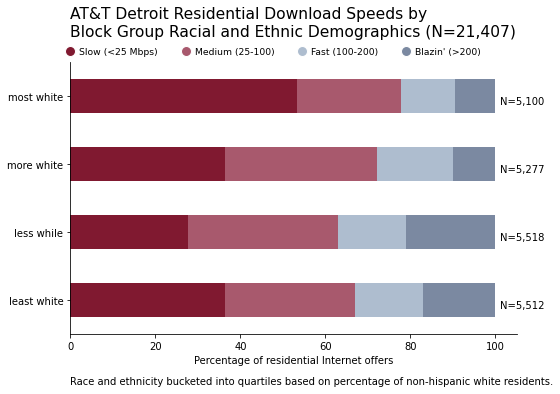

In [61]:
race(_df, location=city)

In [62]:
slowest_race = table_['slowest_race'].iloc[0]
race_sig = True if table_['p_value_race'].iloc[0] < .05 else False

remainder = [_ for _ in race_bins if _ not in slowest_race]
races = ', '.join(remainder[:-1]) + ', and ' + remainder[-1] 

TypeError: argument of type 'bool' is not iterable

In [63]:
md(f"Households in {slowest_race} areas were {'significantly' if race_sig else 'not significantly'} more likely to be offered a slow speed than households in {races} areas.")

NameError: name 'races' is not defined

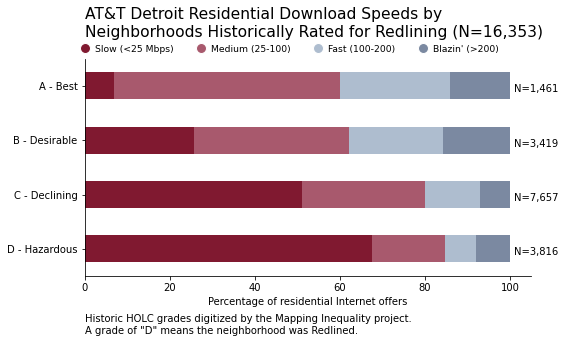

In [64]:
redlining(_df, location=city)